In [1]:
import time
import numpy as np
import pickle
import awkward as ak
import dask_awkward as dak
from distributed import Client
from omegaconf import OmegaConf

from typing import Tuple, List, Dict
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib.pyplot as plt
import matplotlib
plt.style.use(hep.style.CMS)

In [4]:
year = "2018"
load_path = f"/work/users/yun79/stage2_output/BDT_WgtON_original_AN_BDT_Sept27/ggh/{year}/processed_events_bkgMC*.parquet"


processed_events = ak.from_parquet(load_path)
nan_filter = ~np.isnan(ak.to_numpy(processed_events.wgt_nominal_total))
processed_events = processed_events[nan_filter]
region = processed_events.h_peak | processed_events.h_sidebands
# DNN_score_raw is a sigmoid output
bkg = (ak.to_numpy(processed_events.BDT_score[region])) # eval
# bkg = (ak.to_numpy(processed_events.BDT_score_val[region])) # val
bkg_wgt = (ak.to_numpy(processed_events.wgt_nominal_total[region]))
bkg_label = 0*np.ones_like(bkg)


load_path = f"/work/users/yun79/stage2_output/BDT_WgtON_original_AN_BDT_Sept27/ggh/{year}/processed_events_sigMC*.parquet"


processed_events = ak.from_parquet(load_path)
region = processed_events.h_peak | processed_events.h_sidebands
sig = (ak.to_numpy(processed_events.BDT_score[region])) # eval
# sig = (ak.to_numpy(processed_events.BDT_score_val[region])) # val
sig_wgt = (ak.to_numpy(processed_events.wgt_nominal_total[region]))
sig_label = np.ones_like(sig)
# print(np.min(bkg))
# print(np.max(bkg))
# print(np.min(sig))
# print(np.max(sig))
print(bkg.shape)
print(sig.shape)
pred = np.concatenate((bkg,sig), axis=0)
wgt_total = np.concatenate((bkg_wgt,sig_wgt), axis=0)
label = np.concatenate((bkg_label,sig_label), axis=0)
# print(pred.shape)
# print(wgt_total.shape)
# print(label.shape)

(10736495,)
(1302254,)


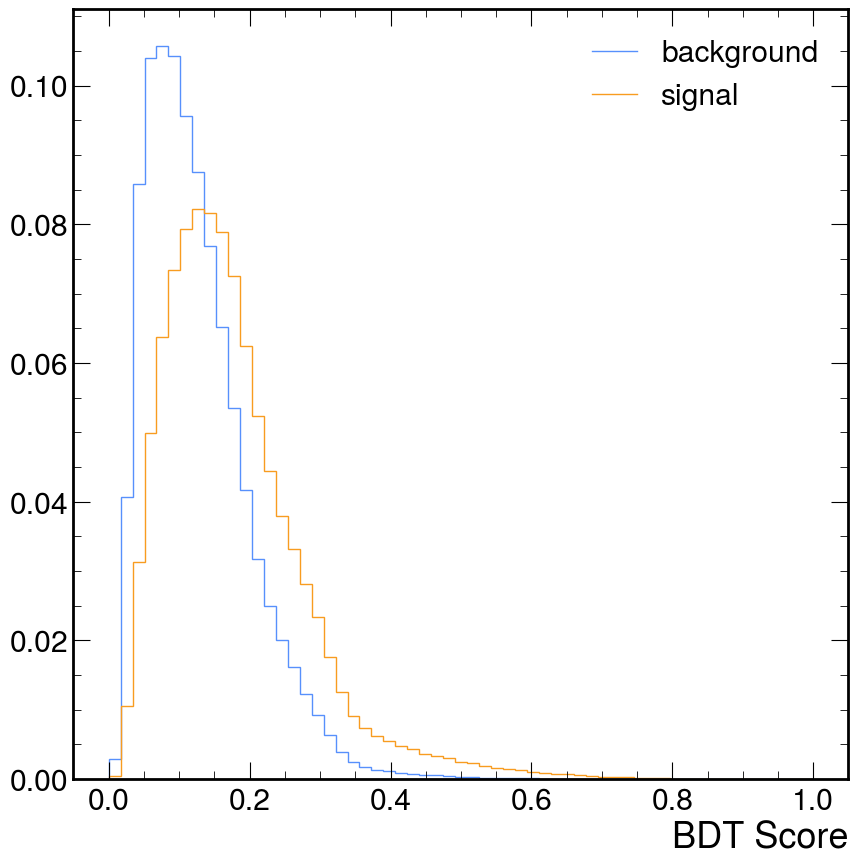

<Figure size 1000x1000 with 0 Axes>

In [5]:
# seperate signal and background
binning = np.linspace(start=0,stop=1, num=60) 
bkg_pred = bkg
bkg_wgt = bkg_wgt / np.sum(bkg_wgt) # normalize
bkg_hist, edges = np.histogram(bkg_pred, bins=binning, weights=bkg_wgt)

sig_pred = sig
sig_wgt = sig_wgt / np.sum(sig_wgt) # normalize
sig_hist, _ = np.histogram(sig_pred, bins=binning, weights=sig_wgt)
# print(f"bkg_hist: {bkg_hist}")
plt.stairs(bkg_hist, edges, label = "background")
plt.stairs(sig_hist, edges, label = "signal")
plt.xlabel('BDT Score')
plt.legend()
plt.savefig(f"6_5_{year}_eval.png")
# plt.savefig(f"6_5_val.png")
# plt.show()
plt.clf()



In [4]:
import numba 

@numba.njit(parallel=True)
def customROC_curve_AN(label, pred, weight):
    """
    generates signal and background efficiency consistent with the AN,
    as described by Fig 4.6 of Dmitry's PhD thesis
    """
    # we assume sigmoid output with labels 0 = background, 1 = signal
    # thresholds = np.linspace(start=0,stop=1, num=10000) 
    thresholds = np.linspace(start=0,stop=1, num=500)
    effBkg_total = -99*np.ones_like(thresholds) 
    effSig_total = -99*np.ones_like(thresholds) 
    # for ix in range(len(thresholds)):
    for ix in numba.prange(len(thresholds)):
        threshold = thresholds[ix]
        # get FP and TP
        positive_filter = (pred >= threshold)
        falsePositive_filter = positive_filter & (label == 0)
        FP = np.sum(weight[falsePositive_filter])#  FP = false positive
        truePositive_filter = positive_filter & (label == 1)
        TP = np.sum(weight[truePositive_filter])#  TP = true positive
        

        # get TN and FN
        negative_filter = (pred < threshold) # just picked negative to be <=
        trueNegative_filter = negative_filter & (label == 0)
        TN = np.sum(weight[trueNegative_filter])#  TN = true negative
        falseNegative_filter = negative_filter & (label == 1)
        FN = np.sum(weight[falseNegative_filter])#  FN = false negative

        

        # effBkg = TN / (FN + TN)
        # effSig = TP / (TP + FP)
        # effBkg = TN / (FP + TN)
        # effSig = TP / (TP + FN)
        effBkg = TN / (TN + FP)
        effSig = FN / (FN + TP)
        effBkg_total[ix] = effBkg
        effSig_total[ix] = effSig

        # print(f"TN: {TN}")
        # print(f"FN: {FN}")
        
        # sanity check
        # assert ((np.sum(positive_filter) + np.sum(negative_filter)) == len(pred))
        # total_yield = FP + TP + FN + TN
        # assert(np.isclose(total_yield, np.sum(weight)))
        # print(f"total_yield: {total_yield}")
        # print(f"np.sum(weight): {np.sum(weight)}")
    print(f"np.sum(effBkg_total ==-99) : {np.sum(effBkg_total ==-99)}")
    print(f"np.sum(effSig_total ==-99) : {np.sum(effSig_total ==-99)}")
    effBkg_total[np.isnan(effBkg_total)] = 1
    effSig_total[np.isnan(effSig_total)] = 1
    return (effBkg_total, effSig_total, thresholds)



In [5]:
# # test
# import numba 

# @numba.njit(parallel=True)
# def customROC_curve_AN(label, pred, weight):
#     """
#     generates signal and background efficiency consistent with the AN,
#     as described by Fig 4.6 of Dmitry's PhD thesis
#     """
#     # we assume sigmoid output with labels 0 = background, 1 = signal
#     # thresholds = np.linspace(start=0,stop=1, num=2500) 
#     thresholds = np.linspace(start=0,stop=1, num=50)
#     effBkg_total = -99*np.ones_like(thresholds) 
#     effSig_total = -99*np.ones_like(thresholds) 
#     # for ix in range(len(thresholds)):
#     for ix in numba.prange(len(thresholds)):
#         threshold = thresholds[ix]
#         # get FP and TP
#         positive_filter = (pred >= threshold)
#         falsePositive_filter = positive_filter & (label == 0)
#         FP = np.sum(weight[falsePositive_filter])#  FP = false positive
#         truePositive_filter = positive_filter & (label == 1)
#         TP = np.sum(weight[truePositive_filter])#  TP = true positive
        

#         # get TN and FN
#         negative_filter = (pred < threshold) # just picked negative to be <=
#         trueNegative_filter = negative_filter & (label == 0)
#         TN = np.sum(weight[trueNegative_filter])#  TN = true negative
#         falseNegative_filter = negative_filter & (label == 1)
#         FN = np.sum(weight[falseNegative_filter])#  FN = false negative

        

#         # effBkg = TN / (FN + TN)
#         # effSig = TP / (TP + FP)
#         # effBkg = TN / (FP + TN)
#         # effSig = TP / (TP + FN)
#         effBkg = TN / (TN + FP)
#         effSig = FN / (FN + TP)
#         # effBkg = FP / (TN + FP)
#         # effSig = TP / (FN + TP)
#         effBkg_total[ix] = effBkg
#         effSig_total[ix] = effSig

#         # print(f"TN: {TN}")
#         # print(f"FN: {FN}")
        
#         # sanity check
#         # assert ((np.sum(positive_filter) + np.sum(negative_filter)) == len(pred))
#         # total_yield = FP + TP + FN + TN
#         # assert(np.isclose(total_yield, np.sum(weight)))
#         # print(f"total_yield: {total_yield}")
#         # print(f"np.sum(weight): {np.sum(weight)}")
#     print(f"np.sum(effBkg_total ==-99) : {np.sum(effBkg_total ==-99)}")
#     print(f"np.sum(effSig_total ==-99) : {np.sum(effSig_total ==-99)}")
#     effBkg_total[np.isnan(effBkg_total)] = 1
#     effSig_total[np.isnan(effSig_total)] = 1
#     return (effBkg_total, effSig_total, thresholds)



In [6]:
eff_bkg, eff_sig, thresholds = customROC_curve_AN(label, pred, wgt_total)
# print(f"eff_sig: {eff_sig}")
plt.figure()  
plt.plot(eff_sig, eff_bkg, label="Stage2 ROC Curve (Eval)")

# plt.vlines(eff_sig, 0, eff_bkg, linestyle="dashed")
plt.vlines(np.linspace(0,1,11), 0, 1, linestyle="dashed", color="grey")
plt.hlines(np.logspace(-4,0,5), 0, 1, linestyle="dashed", color="grey")
# plt.hlines(eff_bkg, 0, eff_sig, linestyle="dashed")
plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
plt.xlabel('Signal eff')
plt.yscale("log")
plt.ylim([0.0001, 1.0])
plt.ylabel('Background eff')
plt.title(f'ROC curve for ggH BDT {year}')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend()
# plt.show()
plt.savefig(f"ROC_curve_{year}_eval.png")
# plt.savefig("ROC_curve_val.png")
plt.clf()

np.sum(effBkg_total ==-99) : 0
np.sum(effSig_total ==-99) : 0


<Figure size 1000x1000 with 0 Axes>

In [7]:
# plot to find the best threshold for signal efficiency
plt.figure()  
plt.plot(thresholds, eff_sig)
plt.ylabel('Signal eff')
plt.xlabel('thresholds')
# plt.show()
plt.savefig(f"Sig_eff_{year}_eval.png")
# plt.savefig("Sig_eff_val.png")
plt.clf()

<Figure size 1000x1000 with 0 Axes>

In [8]:
def findBDT_binVals(thres, eff_sigs, sigEffBinEdges):
    """
    we expect len(sigEffBinEdges) == number of categories + 1,
    we expect sshape of thres == shape of eff_sigs
    """
    bin_vals = []
    for target_eff in sigEffBinEdges:
        print(f"target_eff: {target_eff}")
        for ix in range(1,len(eff_sigs)):
            # print(f"ix: {ix}")
            ith_sigEff = eff_sigs[ix]
            thres_oneb4 = thres[ix-1]
            
            if target_eff <= ith_sigEff:
                print(f"ith_sigEff: {ith_sigEff}")
                print(f"thres_oneb4: {thres_oneb4}")
                bin_vals.append(thres_oneb4)
                break
        print(f"-----------------------------------------")
    return bin_vals


# sigEffBinEdges = [0, 0.3, 0.65, 0.8, 0.95, 1.0] 
sigEffBinEdges = [0.30457106331479633,
 0.6578274705868433,
 0.8062508933940177,
 0.9456462813510415,
 1.0] # Run2 edges
bin_vals = findBDT_binVals(thresholds, eff_sig, sigEffBinEdges)
print(bin_vals) 

target_eff: 0.30457106331479633
ith_sigEff: 0.3082328945819549
thres_oneb4: 0.1623246492985972
-----------------------------------------
target_eff: 0.6578274705868433
ith_sigEff: 0.6619018772454587
thres_oneb4: 0.28456913827655306
-----------------------------------------
target_eff: 0.8062508933940177
ith_sigEff: 0.8068336936767888
thres_oneb4: 0.4168336673346693
-----------------------------------------
target_eff: 0.9456462813510415
ith_sigEff: 0.9458426286914795
thres_oneb4: 0.7635270541082164
-----------------------------------------
target_eff: 1.0
ith_sigEff: 1.0
thres_oneb4: 0.9559118236472945
-----------------------------------------
[0.1623246492985972, 0.28456913827655306, 0.4168336673346693, 0.7635270541082164, 0.9559118236472945]


In [9]:
load_path = f"/work/users/yun79/stage2_output/BDT_WgtON_original_AN_BDT_Sept27/ggh/{year}/processed_events_sigMC*.parquet"

processed_events = ak.from_parquet(load_path)
bdt_eval = processed_events.BDT_score
bdt_val = processed_events.BDT_score_val

In [10]:
np.sum(bdt_eval != bdt_val)

1302253